# Inference with SwinUNETR (Adapted to Binary Segmentation)

This notebook demonstrates the inference process using the Swin UNETR model, a Swin-based transformer for 3D medical image analysis.
The goal of this notebook is to:
- Use SwinUNETR model.
- Perform **binary segmentation** of anatomical structures (lungs + infections vs background)
- Visualize the segmentation results.

**Binary Segmentation Task**: All non-background pixels (lungs and infections) are grouped into a single foreground class, creating a binary classification problem (background vs foreground).

#### DISCLAIMER

For more details, see the original article: [Self-Supervised Pre-Training of Swin Transformers for 3D Medical Image Analysis](https://www.semanticscholar.org/paper/Self-Supervised-Pre-Training-of-Swin-Transformers-Tang-Yang/076a8e778f2e9efb3c2fd45fed534ae9e6035f1b).

>@article{Tang2021SelfSupervisedPO,  
  title={Self-Supervised Pre-Training of Swin Transformers for 3D Medical Image Analysis},  
  author={Yucheng Tang and Dong Yang and Wenqi Li and Holger R. Roth and Bennett A. Landman and Daguang Xu and V. Nath and Ali Hatamizadeh},  
  journal={2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},  
  year={2021},  
  pages={20698-20708},  
  url={https://api.semanticscholar.org/CorpusID:244715046}  
}

## Architecture

SwinUNETR is composed of:
- **Swin Transformer Encoder:** Uses 3D input patches and a hierarchical architecture with *shifted windowing* mechanisms to efficiently compute self-attention. This allows modeling both global and local information at different resolutions, which is crucial for volumetric images.
- **CNN-Based Decoder:** Connected to the encoder via *skip connections* at different resolutions, similar to the UNet architecture, enabling dense inference and recovery of fine spatial details.
- **Segmentation Head:** Attached at the end of the decoder to compute the final segmentation output.

## Setting Environment



In [ ]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 43.3 MB/s eta 0:00:00


In [ ]:
# Custom transform for binary segmentation
from monai.transforms import MapTransform

class ConvertToBinaryLabeld(MapTransform):
    """
    Convert multi-class labels to binary labels.
    All non-zero labels become 1, zero labels remain 0.
    """
    def __init__(self, keys, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key in d:
                # Convert all non-zero labels to 1
                d[key] = (d[key] > 0).to(d[key].dtype)
        return d


In [ ]:
import os
import shutil
import tempfile
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)
from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
import torch
import einops
import warnings


warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading data

In [ ]:
!mkdir -p ../data/images
!mkdir -p ../data/masks

!wget -O ../data/COVID-19-CT-Seg_20cases.zip 'https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1'
!wget -O ../data/Lung_and_Infection_Mask.zip 'https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1'

!unzip -qq ../data/COVID-19-CT-Seg_20cases.zip -d ../data/images
!unzip -qq ../data/Lung_and_Infection_Mask.zip -d ../data/masks

--2025-09-30 02:22:46--  https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3757476/files/COVID-19-CT-Seg_20cases.zip [following]
--2025-09-30 02:22:46--  https://zenodo.org/records/3757476/files/COVID-19-CT-Seg_20cases.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1105395143 (1.0G) [application/octet-stream]
Saving to: ‘../data/COVID-19-CT-Seg_20cases.zip’

../data/COVID-19-CT 100%[===================>]   1.03G  16.1MB/s    in 1m 57s  

2025-09-30 02:24:44 (8.99 MB/s) - ‘../data/COVID-19-CT-Seg_20cases.zip’ saved [1105395143/1105395143]

--2025-09-30 02:24:44--  https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1
Resolving zenodo.org (ze

## Moving data to google drive, for persistence

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the source and destination paths
source_dir = '../data'
destination_dir = '/content/drive/MyDrive/SIBGRAPI/Supervised3D/'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Move the files
for item_name in os.listdir(source_dir):
    source_item = os.path.join(source_dir, item_name)
    destination_item = os.path.join(destination_dir, item_name)
    shutil.move(source_item, destination_item)

print(f"Moved contents of {source_dir} to {destination_dir}")

Mounted at /content/drive
Moved contents of ../data to /content/drive/MyDrive/SIBGRAPI/Supervised3D/


### Checking data

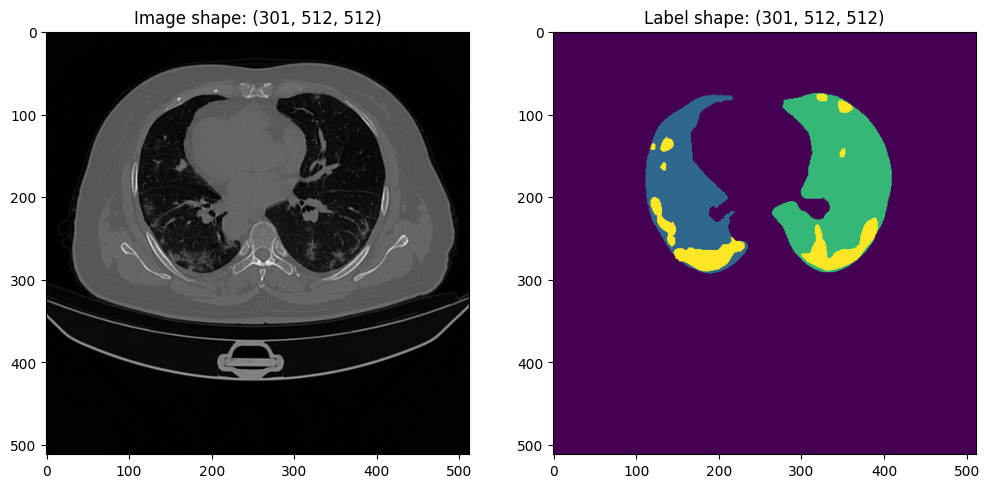

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

root_path = "/content/drive/MyDrive/SIBGRAPI/Supervised3D/"
img_path = root_path + 'images/coronacases_001.nii.gz'
mask_path = root_path + 'masks/coronacases_001.nii.gz'

test_image_nib = nib.load(img_path)
test_mask_nib = nib.load(mask_path)
test_image = np.transpose(test_image_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]
test_mask = np.transpose(test_mask_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_image[test_image.shape[0]//2], cmap='gray')
ax1.set_title(f'Image shape: {test_image.shape}')
ax2.imshow(test_mask[test_mask.shape[0]//2])
ax2.set_title(f'Label shape: {test_mask.shape}')
plt.show()

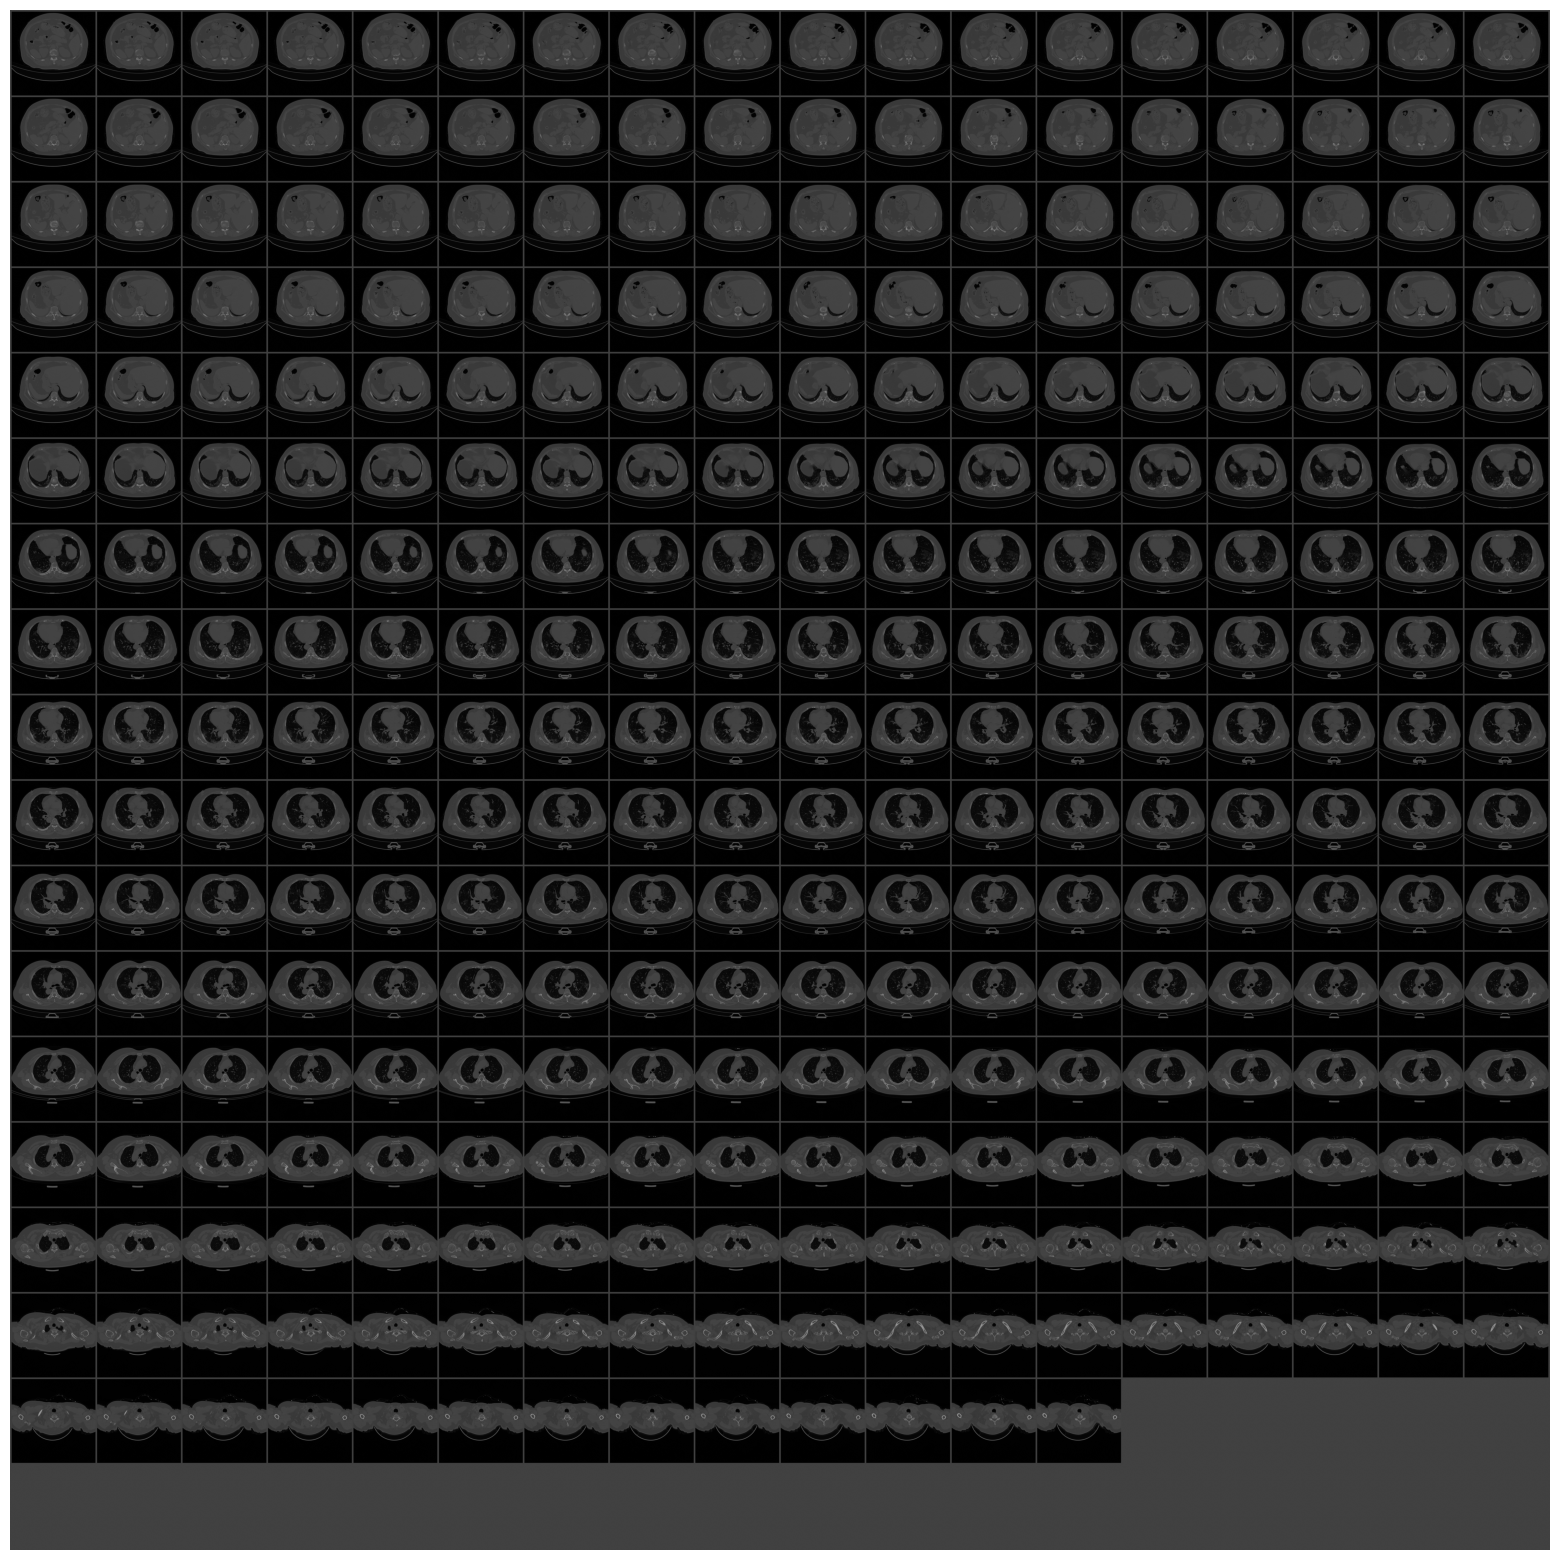

In [ ]:
from skimage.util import montage

fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage(test_image, padding_width=10, fill=1), cmap='gray')
plt.axis('off')
plt.show()

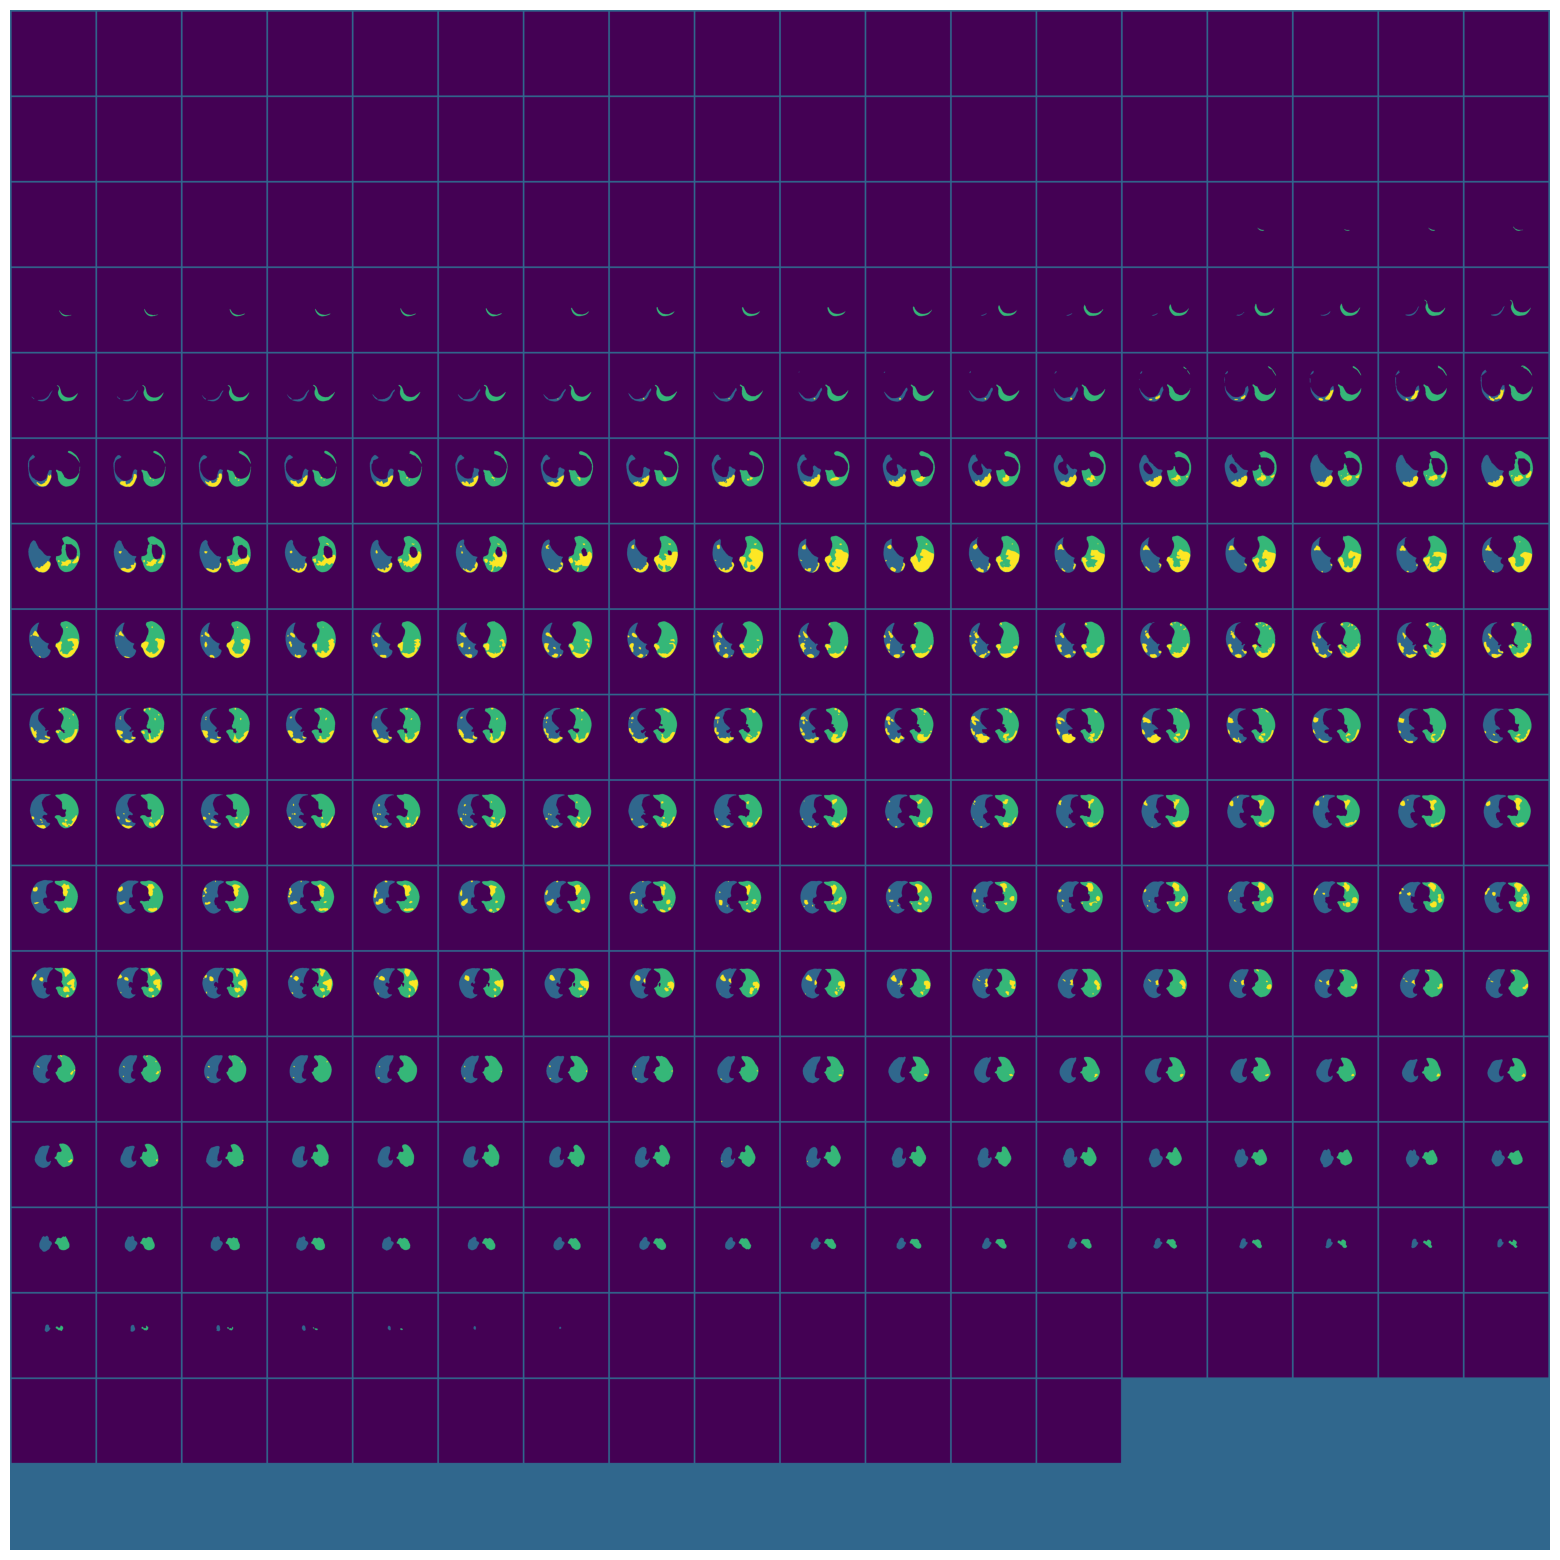

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage(test_mask, padding_width=10, fill=1))
plt.axis('off')
plt.show()

### Transforms

In [ ]:
num_samples = 1
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        ConvertToBinaryLabeld(keys=["label"]),  # Convert to binary segmentation
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
        ConvertToBinaryLabeld(keys=["label"]),  # Convert to binary segmentation
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["image"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        EnsureTyped(keys=["image"], device=device, track_meta=True),
    ]
)

### Creating Dataset


In [ ]:
import glob
import json
import pprint


dataset_json = {
    "labels": {
        "0": "background",
        "1": "foreground (lungs + infections)"
    },
    "tensorImageSize": "3D",
    "training": [],
    "validation": []
}
root_path = "/content/drive/MyDrive/SIBGRAPI/Supervised3D/"
masks_paths = sorted(glob.glob(root_path + 'masks/*.nii.gz'))
for path in masks_paths[:-2]:
    filename = path.rsplit('/', 1)[-1]
    dataset_json["training"].append({
        "image": f'images/{filename}',
        "label": f'masks/{filename}',
    })
for path in masks_paths[-2:]:
    filename = path.rsplit('/', 1)[-1]
    dataset_json["validation"].append({
        "image": f'images/{filename}',
        "label": f'masks/{filename}',
    })

datasets = root_path + 'dataset.json'
with open(datasets, 'w') as outfile:
    json.dump(dataset_json, outfile)

pprint.pprint(dataset_json)

{'labels': {'0': 'background', '1': 'foreground (lungs + infections)'},
 'tensorImageSize': '3D',
 'training': [{'image': 'images/coronacases_001.nii.gz',
               'label': 'masks/coronacases_001.nii.gz'},
              {'image': 'images/coronacases_002.nii.gz',
               'label': 'masks/coronacases_002.nii.gz'},
              {'image': 'images/coronacases_003.nii.gz',
               'label': 'masks/coronacases_003.nii.gz'},
              {'image': 'images/coronacases_004.nii.gz',
               'label': 'masks/coronacases_004.nii.gz'},
              {'image': 'images/coronacases_005.nii.gz',
               'label': 'masks/coronacases_005.nii.gz'},
              {'image': 'images/coronacases_006.nii.gz',
               'label': 'masks/coronacases_006.nii.gz'},
              {'image': 'images/coronacases_007.nii.gz',
               'label': 'masks/coronacases_007.nii.gz'},
              {'image': 'images/coronacases_008.nii.gz',
               'label': 'masks/coronacases_008.

In [ ]:
train_files = load_decathlon_datalist(datasets, True, "training")
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_num=24, cache_rate=1.0, num_workers=2
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=2
)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

set_track_meta(False)

Loading dataset: 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

### Check

Unique values in binary labels: tensor([0., 1.], device='cuda:0')
Label value counts: tensor([9754181, 1277371], device='cuda:0')


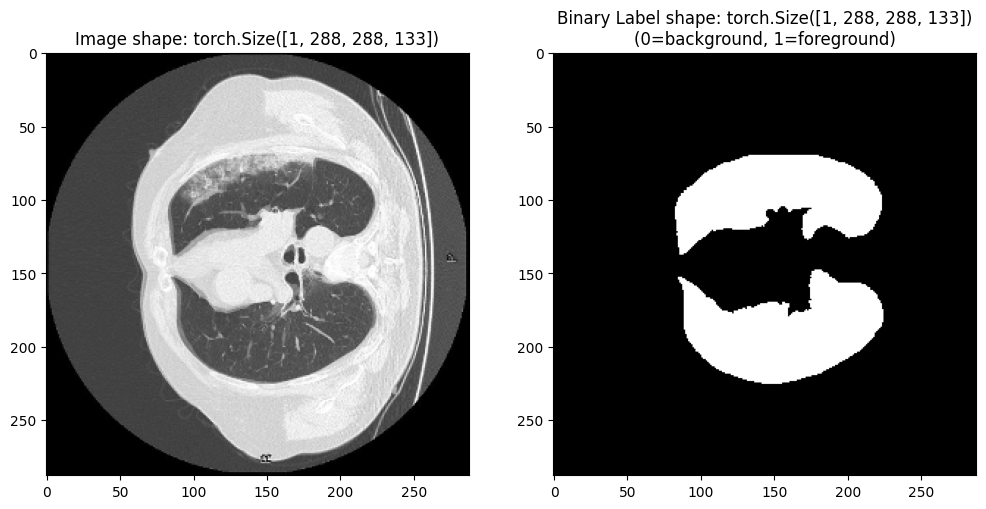

In [ ]:
case_num = 1
slice_num = 50

img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]

# Check unique values in binary labels
unique_vals = torch.unique(label)
print(f"Unique values in binary labels: {unique_vals}")
print(f"Label value counts: {torch.bincount(label.flatten().long())}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(img[0, :, :, slice_num].detach().cpu(), cmap="gray")
ax1.set_title(f'Image shape: {img.shape}')
ax2.imshow(label[0, :, :, slice_num].detach().cpu(), cmap="gray")
ax2.set_title(f'Binary Label shape: {label.shape}\n(0=background, 1=foreground)')
plt.show()

## Model

### Creating Model

In [ ]:
model = SwinUNETR(
    in_channels=1,
    out_channels=2,  # Binary segmentation: background (0) and foreground (1)
    feature_size=48,
    use_checkpoint=True,
).to(device)

### Training

In [ ]:
checkpoints_path = "/content/drive/MyDrive/SIBGRAPI/Supervised3D/checkpoints/"
os.makedirs(checkpoints_path, exist_ok=True)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 1.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), checkpoints_path + "best_metric_model.pth")
                print(f"\nModel Was Saved ! Current Best Avg. Dice: {dice_val_best} Current Avg. Dice: {dice_val}")
            else:
                print(f"\nModel Was Not Saved ! Current Best Avg. Dice: {dice_val_best} Current Avg. Dice: {dice_val}")
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [ ]:
import gc
torch.backends.cudnn.benchmark = True

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Loss function for binary segmentation
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

max_iterations = 3000
eval_num = 100
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
    gc.collect()
    torch.cuda.empty_cache()
model.load_state_dict(torch.load(checkpoints_path + "best_metric_model.pth"))

Training (100 / 3000 Steps) (loss=0.40672):  61%|██████    | 11/18 [00:22<00:37,  5.32s/it]


Model Was Saved ! Current Best Avg. Dice: 0.6947077512741089 Current Avg. Dice: 0.6947077512741089


Training (200 / 3000 Steps) (loss=0.23705):  17%|█▋        | 3/18 [00:13<01:26,  5.79s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8081438541412354 Current Avg. Dice: 0.8081438541412354


Training (300 / 3000 Steps) (loss=0.28043):  72%|███████▏  | 13/18 [00:18<00:19,  3.86s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8081438541412354 Current Avg. Dice: 0.7213516235351562


Training (400 / 3000 Steps) (loss=0.11812):  28%|██▊       | 5/18 [00:14<01:01,  4.71s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8616575002670288 Current Avg. Dice: 0.8616575002670288


Training (500 / 3000 Steps) (loss=0.52775):  83%|████████▎ | 15/18 [00:19<00:11,  3.80s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8616575002670288 Current Avg. Dice: 0.8104329109191895


Training (600 / 3000 Steps) (loss=0.21236):  39%|███▉      | 7/18 [00:15<00:47,  4.33s/it]


Model Was Saved ! Current Best Avg. Dice: 0.9429565668106079 Current Avg. Dice: 0.9429565668106079


Training (700 / 3000 Steps) (loss=0.09736):  94%|█████████▍| 17/18 [00:21<00:03,  3.79s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9429565668106079 Current Avg. Dice: 0.8253359794616699


Training (800 / 3000 Steps) (loss=0.20006):  50%|█████     | 9/18 [00:16<00:37,  4.17s/it]


Model Was Saved ! Current Best Avg. Dice: 0.9506388902664185 Current Avg. Dice: 0.9506388902664185


Training (900 / 3000 Steps) (loss=0.06715):   6%|▌         | 1/18 [00:11<03:11, 11.28s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9506388902664185 Current Avg. Dice: 0.8614461421966553


Training (1000 / 3000 Steps) (loss=0.13314):  61%|██████    | 11/18 [00:17<00:27,  3.88s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9506388902664185 Current Avg. Dice: 0.8170276880264282


Training (1100 / 3000 Steps) (loss=0.05923):  17%|█▋        | 3/18 [00:12<01:22,  5.47s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9506388902664185 Current Avg. Dice: 0.8518825769424438


Training (1200 / 3000 Steps) (loss=0.06806):  72%|███████▏  | 13/18 [00:19<00:20,  4.05s/it]


Model Was Saved ! Current Best Avg. Dice: 0.9562877416610718 Current Avg. Dice: 0.9562877416610718


Training (1300 / 3000 Steps) (loss=0.06323):  28%|██▊       | 5/18 [00:13<00:57,  4.46s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9562877416610718 Current Avg. Dice: 0.955695390701294


Training (1400 / 3000 Steps) (loss=0.04329):  83%|████████▎ | 15/18 [00:20<00:12,  4.07s/it]


Model Was Saved ! Current Best Avg. Dice: 0.9699194431304932 Current Avg. Dice: 0.9699194431304932


Training (1500 / 3000 Steps) (loss=0.14414):  39%|███▉      | 7/18 [00:14<00:44,  4.08s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9699194431304932 Current Avg. Dice: 0.9388704299926758


Training (1600 / 3000 Steps) (loss=0.06356):  94%|█████████▍| 17/18 [00:21<00:03,  4.00s/it]


Model Was Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9748416543006897


Training (1700 / 3000 Steps) (loss=0.06723):  50%|█████     | 9/18 [00:16<00:35,  3.92s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9717848300933838


Training (1800 / 3000 Steps) (loss=0.15156):   6%|▌         | 1/18 [00:11<03:14, 11.43s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9702935218811035


Training (1900 / 3000 Steps) (loss=0.07114):  61%|██████    | 11/18 [00:17<00:26,  3.85s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9739162921905518


Training (2000 / 3000 Steps) (loss=0.10244):  17%|█▋        | 3/18 [00:12<01:22,  5.48s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9492998123168945


Training (2100 / 3000 Steps) (loss=0.08692):  72%|███████▏  | 13/18 [00:18<00:19,  3.86s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9708463549613953


Training (2200 / 3000 Steps) (loss=0.05489):  28%|██▊       | 5/18 [00:13<00:57,  4.41s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9062930345535278


Training (2300 / 3000 Steps) (loss=0.06024):  83%|████████▎ | 15/18 [00:19<00:11,  3.81s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9664694666862488


Training (2400 / 3000 Steps) (loss=0.03976):  39%|███▉      | 7/18 [00:14<00:44,  4.07s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9720460176467896


Training (2500 / 3000 Steps) (loss=0.52344):  94%|█████████▍| 17/18 [00:21<00:03,  3.81s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.8822313547134399


Training (2600 / 3000 Steps) (loss=0.78768):  50%|█████     | 9/18 [00:16<00:35,  3.92s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.971915066242218


Training (2700 / 3000 Steps) (loss=0.53390):   6%|▌         | 1/18 [00:11<03:14, 11.43s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.973724901676178


Training (2800 / 3000 Steps) (loss=0.05536):  61%|██████    | 11/18 [00:17<00:27,  3.86s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9736172556877136


Training (2900 / 3000 Steps) (loss=0.16075):  17%|█▋        | 3/18 [00:12<01:21,  5.46s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9539937973022461


Training (3000 / 3000 Steps) (loss=0.09062):  72%|███████▏  | 13/18 [00:18<00:19,  3.81s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.9748416543006897 Current Avg. Dice: 0.9673569202423096


Training (3005 / 3000 Steps) (loss=0.07923): 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


<All keys matched successfully>

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} at iteration: {global_step_best}")

train completed, best_metric: 0.9748 at iteration: 1600


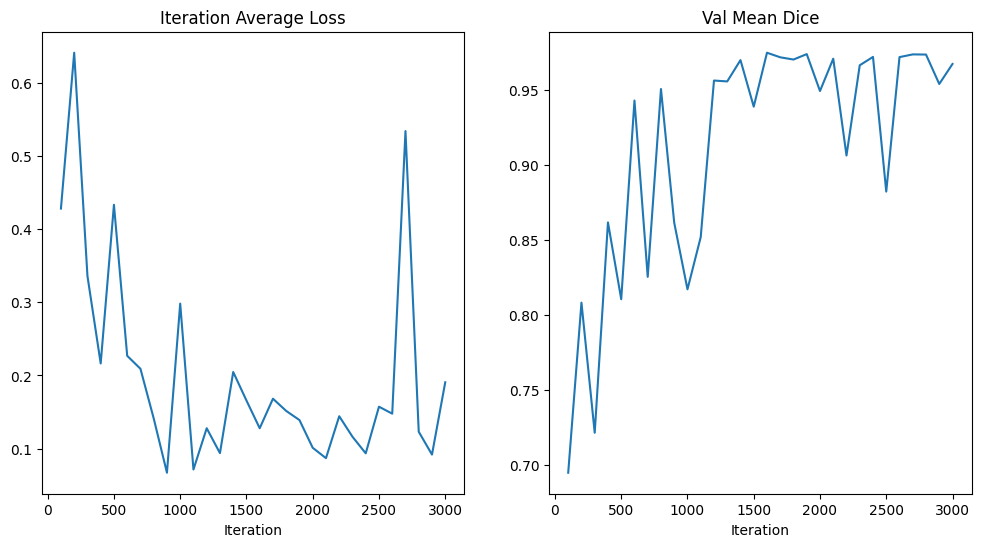

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Inference

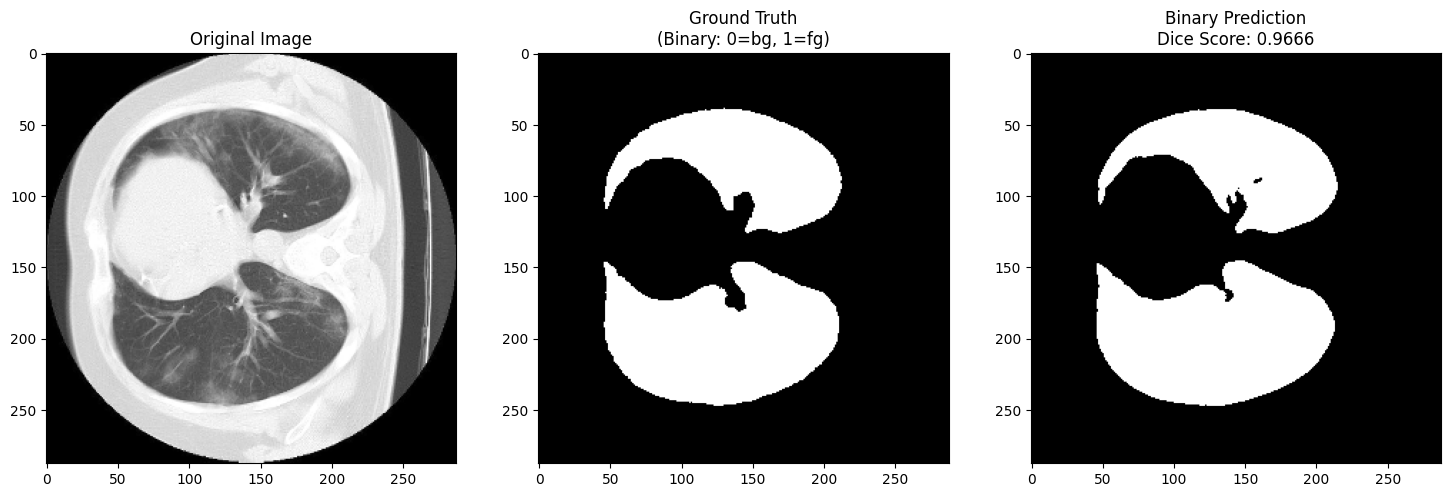

Prediction unique values: tensor([0, 1], device='cuda:0')
Ground truth unique values: tensor([0., 1.], device='cuda:0')


In [ ]:
case_num = 0
slice_num = 50

model.load_state_dict(torch.load(checkpoints_path + "/best_metric_model.pth"))
model.eval()
with torch.no_grad():
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    # Get binary predictions
    val_outputs_binary = torch.argmax(val_outputs, dim=1)

    # Calculate Dice score for this case
    dice_score = 2.0 * torch.sum(val_outputs_binary * val_labels) / (torch.sum(val_outputs_binary) + torch.sum(val_labels) + 1e-8)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    ax1.set_title('Original Image')
    ax2.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    ax2.set_title('Ground Truth\n(Binary: 0=bg, 1=fg)')
    ax3.imshow(val_outputs_binary.detach().cpu()[0, :, :, slice_num], cmap="gray")
    ax3.set_title(f'Binary Prediction\nDice Score: {dice_score:.4f}')
    plt.show()

    print(f"Prediction unique values: {torch.unique(val_outputs_binary)}")
    print(f"Ground truth unique values: {torch.unique(val_labels)}")

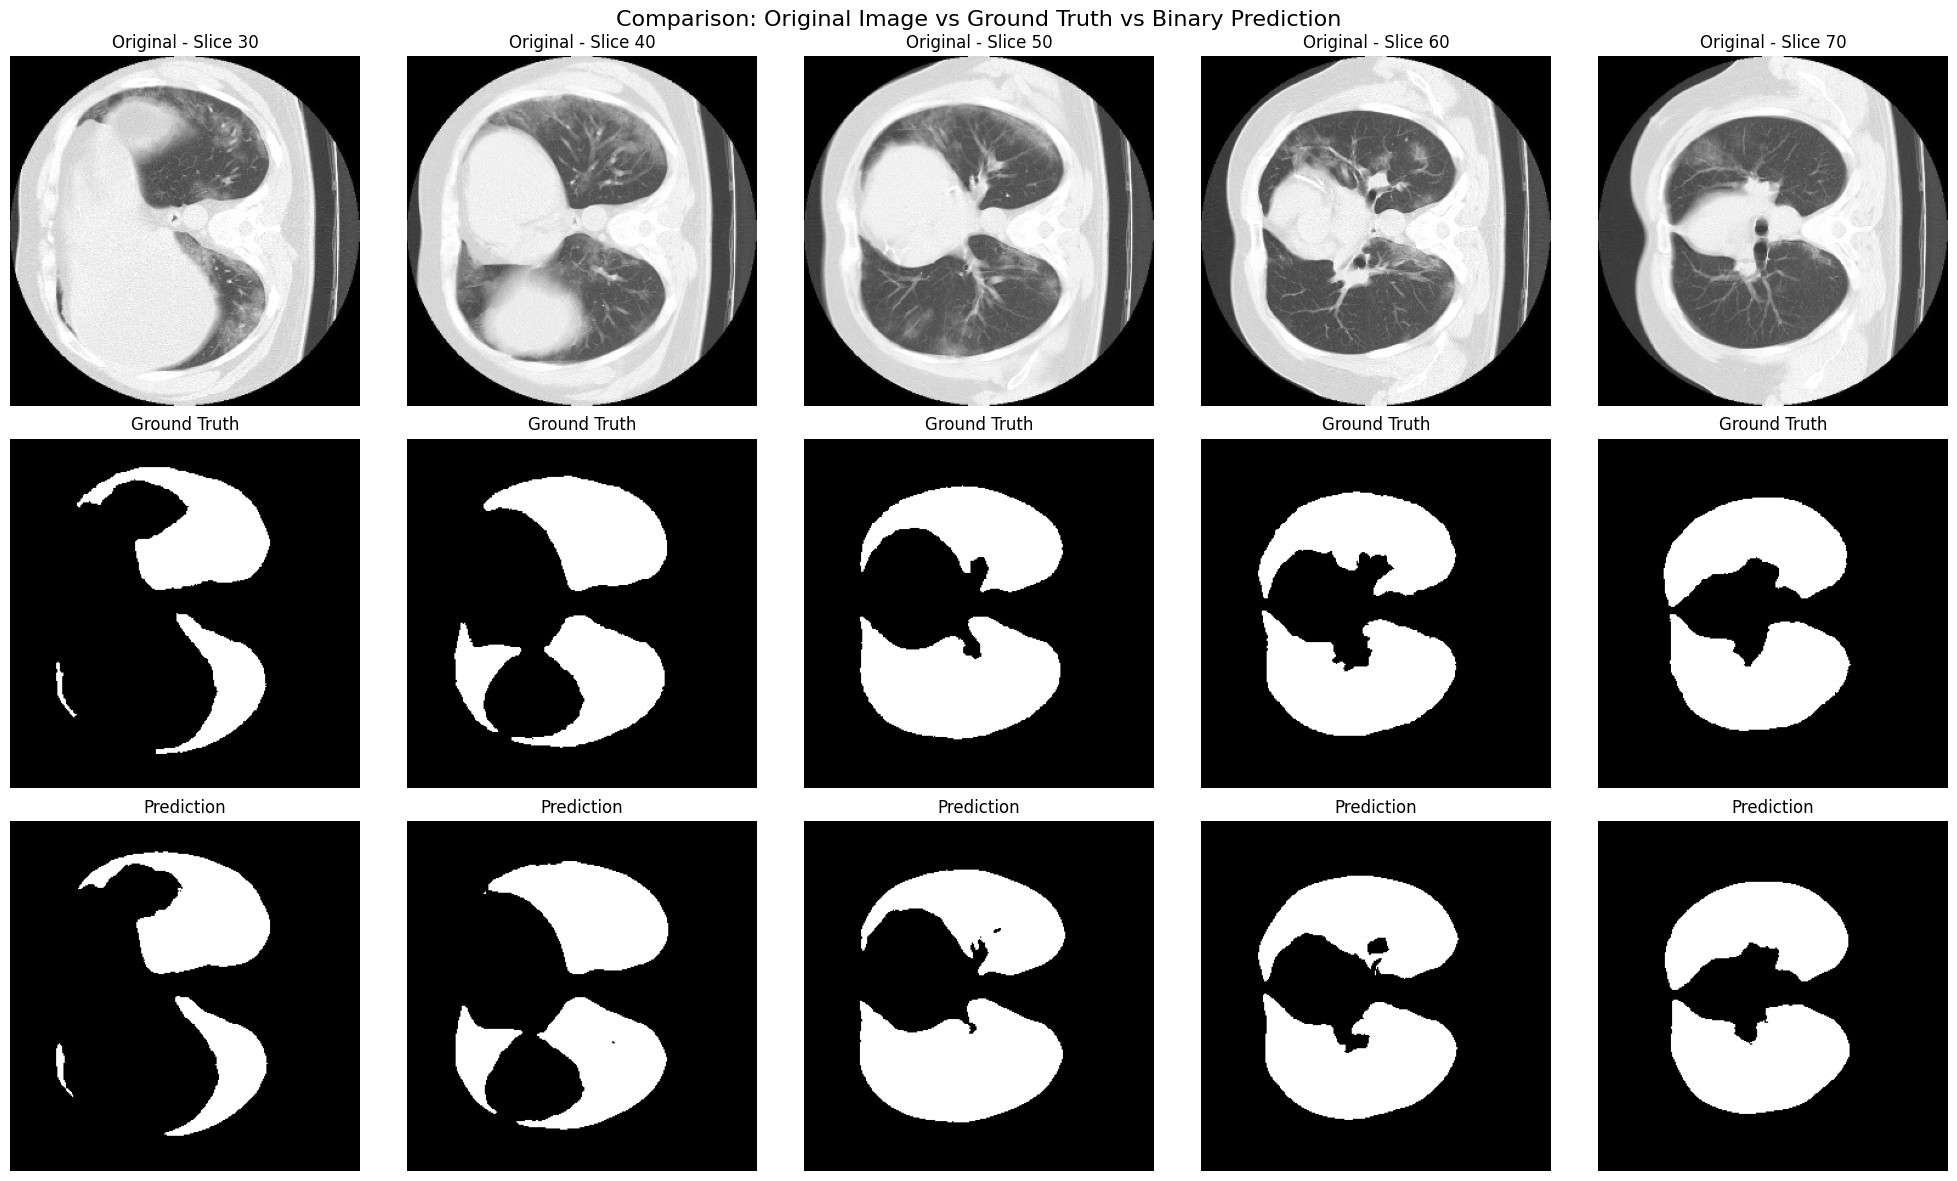

Volumetric Dice Score: 0.9666


In [ ]:
### Detailed Visualization

slice_indices = [30, 40, 50, 60, 70]

fig, axes = plt.subplots(3, len(slice_indices), figsize=(20, 12))
fig.suptitle('Comparison: Original Image vs Ground Truth vs Binary Prediction', fontsize=16)

for i, slice_idx in enumerate(slice_indices):
    # Original Image
    axes[0, i].imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_idx], cmap="gray")
    axes[0, i].set_title(f'Original - Slice {slice_idx}')
    axes[0, i].axis('off')

    # Ground truth
    axes[1, i].imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_idx], cmap="gray")
    axes[1, i].set_title('Ground Truth')
    axes[1, i].axis('off')

    # Prediction
    axes[2, i].imshow(val_outputs_binary.detach().cpu()[0, :, :, slice_idx], cmap="gray")
    axes[2, i].set_title('Prediction')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Segmentation statistics
total_pixels = val_labels.numel()
foreground_gt = torch.sum(val_labels).item()
foreground_pred = torch.sum(val_outputs_binary).item()

print(f"Volumetric Dice Score: {dice_score:.4f}")